In [27]:
import matplotlib.pyplot as plt
import numpy as np
import seawater
import xarray as xr
import scipy.signal as sp
import pandas as pd
import math
import sys
import time


np.set_printoptions(threshold=50)

%matplotlib inline
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## Integrate PSSC in ONAV
This notebook contains the update as we move forward integrating Potential Sub-Surface channel variable in Navigator following option 3 (A fixed frequency cutoff value) 
### Importing the sample profile

In [28]:
profile = pd.read_csv("sample-pssc-profiles/ts_giops_day_2021-01-22T17_20_15.578175_POSITIVE.csv", header=2)
profile.columns

Index(['Latitude', 'Longitude', 'Depth (m)', 'Pressure', 'Salinity',
       'Temperature', 'Sound Speed'],
      dtype='object')

Text(0.5, 0, 'Speed of sound [m/s]')

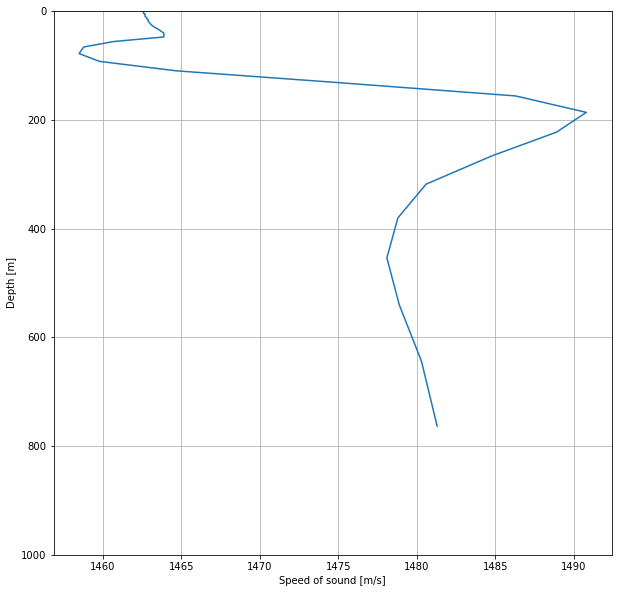

In [31]:
depth = profile['Depth (m)']
Profile_sspeed = profile['Sound Speed']
temperature = profile ['Temperature']
salinity = profile ['Salinity']
latitude = profile['Latitude']
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(profile['Sound Speed'], profile['Depth (m)'])
ax.grid(True)
ax.set_ylim([1000,0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Speed of sound [m/s]')

### Bringing in functions from Navigator
These functions below are from Ocean-Data-Map-Project/data/calculated_parser/functions.py

https://github.com/DFO-Ocean-Navigator/Ocean-Data-Map-Project/blob/master/data/calculated_parser/functions.py

In [32]:
def __calc_pressure(depth, latitude):
    pressure = []
    try:
        pressure = [seawater.pres(d, latitude) for d in depth]
    except TypeError:
        pressure = seawater.pres(depth, latitude)

    return np.array(pressure)

def __validate_depth_lat_temp_sal(depth, latitude, temperature, salinity):

    if type(depth) is not np.ndarray:
        depth = np.array(depth)

    if type(latitude) is not np.ndarray:
        latitude = np.array(latitude)

    if type(temperature) is not np.ndarray:
        temperature = np.array(temperature)

    if type(salinity) is not np.ndarray:
        salinity = np.array(salinity)

    return depth, latitude, np.squeeze(temperature), np.squeeze(salinity)

def sspeed(depth, latitude, temperature, salinity):
    """
    Calculates the speed of sound.
    Required Arguments:
    * depth: The depth(s) in meters
    * latitude: The latitude(s) in degrees North
    * temperature: The temperatures(s) in Celsius
    * salinity: The salinity (unitless)
    """

    depth, latitude, temperature, salinity = __validate_depth_lat_temp_sal(
        depth, latitude, temperature, salinity)

    press = __calc_pressure(depth, latitude)

    if salinity.shape != press.shape:
        # pad array shape to match otherwise seawater freaks out
        press = press[..., np.newaxis]

    speed = seawater.svel(salinity, temperature, press)
    return np.squeeze(speed)

In [30]:
calculated_sspeed = sspeed(depth, latitude, temperature, salinity)
calculated_sspeed.shape

NameError: name 'latitude' is not defined

### The functions to detect sub-surface channel (Single point calculation)

In [33]:
def calculate_del_C(depth,latitude,temperature, salinity, freq_cutoff):
    """
     Calculate ΔC from a given sound profile and freq cutoff
     Required Arguments:
        * depth: The depth(s) in meters
        * latitude: The latitude(s) in degrees North
        * temperature: The temperatures(s) in Celsius
        * salinity: The salinity (unitless)
        * freq_cutoff: Desired frequency cutoff in Hz
     Returns the value of ΔC, which will later be used inside the 
    """
    depth, latitude, temperature, salinity = __validate_depth_lat_temp_sal(depth, latitude, temperature, salinity)
    
    soundspeed = sspeed(depth, latitude, temperature, salinity);
    print(soundspeed.shape)
    # Getting Cmin from the sound speed profile
    first_local_minimum = sp.find_peaks(-soundspeed)[0][0]
    Cmin = soundspeed[first_local_minimum]
    #Calculating del_Z
    local_maximum = sp.find_peaks(soundspeed)[0][0]
    channel_start_depth = depth[local_maximum]
    channel_end_depth = np.interp(soundspeed[local_maximum], soundspeed, depth) 
    del_Z = channel_end_depth - channel_start_depth
    # print(channel_start_depth)
    # Final calculation of delC
    numerator = freq_cutoff * del_Z
    denominator = 0.2652 * Cmin
    final_denom = numerator/denominator
    final_denom =np.power(final_denom,2)
    delC = float(Cmin/final_denom)
    return delC

#calculate_del_C(depth,latitude, temperature, salinity, 2755.03);

In [34]:
"""
     Detect if there is sub-surface channel. 
     Required Arguments:
        * depth: Depth in meters
        * sspeed: Sound speed in m/s
     Returns 1 if the profile has a sub-surface channel, 0 if the profile does not have a sub-surface channel
"""
def detect_potential_sub_surface_channel_v3(depth, latitude,temperature, salinity, freq_cutoff = 2755.03 )-> bool:
    has_PSSC = 0
    del_C = calculate_del_C(depth,latitude,temperature, salinity, freq_cutoff)
    # Trimming the profile considering the depth above 1000m
    depth = depth[depth<1000]
    sspeed = sspeed[0:(len(depth))]
    # detecting the local minima and local maxima for the sound speed profile
    local_minima = sp.find_peaks(-sspeed)[0] # get the index array of local minima
    local_maxima = sp.find_peaks(sspeed)[0] # get the index array of local maxima
    if len(local_minima)>=2: #if there are 2 or more minima
        p1 = 0 # surface
        p2 = local_minima[0] #first minimum
        if len(local_maxima)>=2: # if there are more than one maxima
            p1 = local_maxima[0] #first maximum
            p3 = local_maxima[1] #second maximum
        else: #only one local maximum
            p3 =  local_maxima[0] 
            if p3 < p2: # the only one maxima is higher in the water column than the minima
                has_PSSC=0
        # print("p1 p2 p3 : " +str(p1)+" "+str(p2)+" "+str(p3))
        p1_sound_speed = sound_speed[p1]
        p2_sound_speed = sound_speed[p2]
        p3_sound_speed = sound_speed[p3]
    
        c1 = abs(p1_sound_speed-p2_sound_speed) 
        c2 = abs(p3_sound_speed-p2_sound_speed)
        #print("c1 = "+ str(c1) +"m/s")
        #print("c2 = "+ str(c2) +"m/s")
    
        if c1> del_C and c2> del_C: # Changing this comparison to check with the calculated ΔC
            has_PSSC =1
        else:
            has_PSSC =0
    else:
        has_PSSC =0 
    #print(local_minima)
    #print(local_maxima)
    return has_PSSC

### Transforming the function for inputs from NetCDF file

In [35]:
d = xr.open_dataset('data/2019100100_000_3D_ps5km60N.nc')
d

<xarray.Dataset>
Dimensions:              (depth: 75, time: 1, xc: 1770, yc: 1610)
Coordinates:
  * xc                   (xc) float32 0.0 5000.0 10000.0 ... 8840000.0 8845000.0
  * yc                   (yc) float32 0.0 5000.0 10000.0 ... 8040000.0 8045000.0
    latitude             (yc, xc) float32 ...
    longitude            (yc, xc) float32 ...
  * depth                (depth) float32 0.50753 1.55757 ... 5698.06 5902.06
  * time                 (time) datetime64[ns] 2019-10-01
Data variables:
    polar_stereographic  |S1 ...
    votemper             (time, depth, yc, xc) float32 ...
    vosaline             (time, depth, yc, xc) float32 ...
    vozocrtx             (time, depth, yc, xc) float32 ...
    vomecrty             (time, depth, yc, xc) float32 ...
Attributes:
    Conventions:      CF-1.6
    title:            Time-averaged sea ice and ocean forecast fields
    institution:      The Canadian Centre for Meteorological and Environmenta...
    source:           Regional Ice Oce

In [36]:
depth = d.depth.values
temp = d.votemper.values
sal = d.vosaline.values
lat = d.latitude.values

In [38]:
depth2 = depth[depth<1000]
depth2.shape
temp = temp-273.15


In [39]:
temp2 = temp[:,0:len(depth2),:,:]
print(temp2.shape)
sal2 =  sal[:,0:len(depth2),:,:]
print(sal2.shape)

(1, 46, 1610, 1770)
(1, 46, 1610, 1770)


In [40]:
#sound_speed = np.ma.array(sspeed(depth2, lat, temp2, sal2), fill_value=np.nan)
sound_speed = sspeed(depth2, lat, temp2, sal2)
#sound_speed

/home/sourav/.conda/envs/navigator/lib/python3.6/site-packages/seawater/eos80.py:928: RuntimeWarning: invalid value encountered in sqrt
  return Cw + A * s + B * s * s ** 0.5 + D * s ** 2


In [41]:
start = time.time()
sound_speed.shape
minima = np.apply_along_axis(sp.find_peaks,0,-sound_speed)
end = time.time()
print(end-start)
minima.shape

41.71608328819275


(2, 1610, 1770)

__need to check it for an expected size of soundspeed__ 

In [44]:
sound_speed_sliced = sound_speed[:,200:286,-126:]
sound_speed_sliced.shape
sound_speed_sliced_test = sound_speed[:,200:215,-15:]
sound_speed_sliced_test.shape

(46, 15, 15)

In [45]:
start = time.time()
minima_alt = np.apply_along_axis(sp.find_peaks,0,-sound_speed_sliced_test)
end = time.time()
print(end-start)
minima_alt = minima_alt[0]
minima_alt

0.005783557891845703


array([[array([4]), array([4]), array([4]), ..., array([5]), array([6]),
        array([6])],
       [array([ 3, 10]), array([3]), array([ 3, 10]), ..., array([7]),
        array([7]), array([7])],
       [array([3]), array([3]), array([3]), ..., array([7]), array([7]),
        array([], dtype=int64)],
       ...,
       [array([8]), array([8]), array([8]), ..., array([ 9, 11]),
        array([9]), array([9])],
       [array([8]), array([ 8, 10]), array([10]), ..., array([ 9, 11]),
        array([9]), array([8])],
       [array([ 8, 10]), array([], dtype=int64), array([], dtype=int64),
        ..., array([ 9, 11]), array([9]), array([8])]], dtype=object)

In [68]:
it = np.nditer(minima_alt,flags=['refs_ok','multi_index'],op_flags=['readonly'])
for x in it:
    print("x :"+str(type(x)))
    print(x.shape)
    print(x.size)
    #print(len(x))
    print("x.tolist().size :"+str(x.tolist().size))
    print("---------")
    
    

x :<class 'numpy.ndarray'>
()
1
x.tolist().size :1
---------
x :<class 'numpy.ndarray'>
()
1
x.tolist().size :1
---------
x :<class 'numpy.ndarray'>
()
1
x.tolist().size :1
---------
x :<class 'numpy.ndarray'>
()
1
x.tolist().size :2
---------
x :<class 'numpy.ndarray'>
()
1
x.tolist().size :1
---------
x :<class 'numpy.ndarray'>
()
1
x.tolist().size :1
---------
x :<class 'numpy.ndarray'>
()
1
x.tolist().size :1
---------
x :<class 'numpy.ndarray'>
()
1
x.tolist().size :1
---------
x :<class 'numpy.ndarray'>
()
1
x.tolist().size :1
---------
x :<class 'numpy.ndarray'>
()
1
x.tolist().size :1
---------
x :<class 'numpy.ndarray'>
()
1
x.tolist().size :1
---------
x :<class 'numpy.ndarray'>
()
1
x.tolist().size :1
---------
x :<class 'numpy.ndarray'>
()
1
x.tolist().size :1
---------
x :<class 'numpy.ndarray'>
()
1
x.tolist().size :1
---------
x :<class 'numpy.ndarray'>
()
1
x.tolist().size :1
---------
x :<class 'numpy.ndarray'>
()
1
x.tolist().size :2
---------
x :<class 'numpy.ndarray

In [ ]:
first_minimum = np.empty_like(minima_alt, dtype='int64')
start = time.time()
it = np.nditer(minima_alt,flags=['refs_ok','multi_index'])
for x in it:
    minima_size = x.tolist().size
    first_minimum[it.multi_index]= x.tolist()[0] if minima_size>0 else -1
end = time.time()
print("Execution time :",end-start," seconds")
first_minimum

In [ ]:
first_minimum

In [ ]:
Cmin = np.take_along_axis(sound_speed_sliced, first_minimum[np.newaxis,:, :], axis=0)
Cmin

Testing if this worked. Checking it with directly indexing the actual value and output. 

In [ ]:
sound_speed_sliced[10,0,-1]

Squeezing the ndarray to remove the 0th axis of length 1

In [ ]:
print(Cmin.shape)
Cmin = np.squeeze(Cmin)
print(Cmin.shape)

In [ ]:
Cmin[first_minimum==-1] = np.nan


In [ ]:
Cmin

In [ ]:
maxima_alt =  np.apply_along_axis(sp.find_peaks,0,sound_speed_sliced)
maxima_alt.shape

In [ ]:
maxima_alt = maxima_alt[0]
first_maximum = np.empty_like(maxima_alt, dtype='int64')
it = np.nditer(maxima_alt,flags=['refs_ok','multi_index'])
for x in it:
    array_size = x.tolist().size
    first_maximum[it.multi_index] =x.tolist()[0] if array_size>0 else -1 
first_maximum.shape


In [84]:
def calculate_del_C(depth,soundspeed,minima,maxima,freq_cutoff):
    """
     Calculate ΔC from a given sound profile and freq cutoff
     Required Arguments:
        * depth: The depth(s) in meters
        * soundspeed: Speed of sound in m/s
        * minima: Minima ndarray of Speed of sound, which contains the index where the minima occurs
        * maxima: Maxima ndarray of Speed of sound,  which contains the index where the maxima occurs
        * freq_cutoff: Desired frequency cutoff in Hz
     Returns the value of ΔC, which will later be used inside the PSSC detection method
    """
    # Getting Cmin from the sound speed profile
    first_minimum = np.empty_like(minima, dtype='int64')
    # TODO: need to look at alternative for the following operation
    it = np.nditer(minima,flags=['refs_ok','multi_index'])
    for x in it:
        array_size = x.tolist().size
        first_minimum[it.multi_index]= x.tolist()[0] if array_size>0 else -1
    Cmin = np.squeeze(np.take_along_axis(soundspeed, first_minimum[np.newaxis,:, :], axis=0))
    Cmin[first_minimum==-1] = np.nan
    #calculating delZ
    first_maximum = np.empty_like(maxima, dtype='int64')
    it = np.nditer(maxima,flags=['refs_ok','multi_index'])
    for x in it:
        array_size = x.tolist().size
        first_maximum[it.multi_index] =x.tolist()[0] if array_size>0 else -1 
    channel_start_depth = depth[first_maximum]
    channel_start_depth[first_maximum==-1] = np.nan
    Cmax = np.squeeze(np.take_along_axis(soundspeed, first_maximum[np.newaxis,:, :], axis=0))
    Cmax[first_minimum==-1] = np.nan
    #channel_end_depth = np.apply_along_axis(np.interp,0, Cmax,soundspeed,depth) 
    channel_end_depth = np.empty_like(Cmax,dtype='float')
    it = np.nditer(Cmax,flags=['refs_ok','multi_index'])
    for x in it:
        channel_end_depth[it.multi_index] = np.interp(x, soundspeed[:,it.multi_index[0], it.multi_index[1]],depth)
    del_Z = channel_end_depth-channel_start_depth
    numerator = freq_cutoff * del_Z
    denominator = 0.2652 * Cmin
    final_denom = numerator/denominator 
    final_denom = np.power(final_denom,2)
    delC = Cmin/final_denom
    #print(delC)
    return delC

def potentialsubsurfacechannel(depth, latitude,temperature, salinity, freq_cutoff = 2755.03 )-> np.ndarray:
#def potentialsubsurfacechannel(depth, sound_speed, freq_cutoff = 2755.03 )-> bool:   
    """
     Detect if there is sub-surface channel. 
     Required Arguments:
        * depth: Depth in meters
        * latitude: Latitude in degrees North
        * temperature: Temperatures in Celsius
        * salinity: Salinity
        * freq_cutoff: Desired frequency cutoff in Hz
     Returns 1 if the profile has a sub-surface channel, 0 if the profile does not have a sub-surface channel
    """
    depth, latitude, temperature, salinity = __validate_depth_lat_temp_sal(
        depth, latitude, temperature, salinity)
    # Trimming the profile considering the depth above 1000m
    depth = depth[depth<1000]
    depth_length = len(depth)
    temp = temperature[0:depth_length,:,:]
    sal =  salinity[0:depth_length,:,:]
    sound_speed = sspeed(depth, latitude, temp, sal)
    minima = np.apply_along_axis(sp.find_peaks,0,-sound_speed)[0] # selecting the first item
    maxima = np.apply_along_axis(sp.find_peaks,0, sound_speed)[0]
    delC = calculate_del_C(depth,sound_speed,minima,maxima, freq_cutoff)
    #print(minima)
    
    hasPSSC = np.zeros_like(minima, dtype='float')
    
    it = np.nditer(minima,flags=['refs_ok','multi_index'])
    for minima_array in it:
        minima_list = minima_array.tolist()
        maxima_list = maxima[it.multi_index].tolist()
        if len(minima_list)>=2:
            p1 = 0
            p2 = minima[it.multi_index].tolist()[0]
            if len(maxima_list) >=2:
                p1 = maxima_list[0]
                p3 = maxima_list[1]
            else:
                p3= maxima_list[0]
            if p3 > p2: #if the only maximum is not higher in the water column than the minima
                p1_sound_speed = sound_speed[p1,it.multi_index[0], it.multi_index[1]]
                p2_sound_speed = sound_speed[p2,it.multi_index[0], it.multi_index[1]]
                p3_sound_speed = sound_speed[p3,it.multi_index[0], it.multi_index[1]]
                
                c1 = abs(p1_sound_speed-p2_sound_speed) 
                c2 = abs(p3_sound_speed-p2_sound_speed)
                
                if c1> delC[it.multi_index] and c2> delC[it.multi_index]: 
                    hasPSSC[it.multi_index]= 1
                                                        
    return hasPSSC

Preparing test data to test the function

In [86]:
d = xr.open_dataset('data/2019100100_000_3D_ps5km60N.nc')
depth = d.depth.values
temp = d.votemper.values
sal = d.vosaline.values
lat = d.latitude.values

In [87]:
print(temp.shape)
print(sal.shape)

(1, 75, 1610, 1770)
(1, 75, 1610, 1770)


Resizing the dataset to test the expected size

In [88]:
temp = temp[:,:,200:286,-126:]
temp = temp-273.15
sal = sal[:,:,200:286,-126:]
lat = lat [200:286,-126:]
print(temp.shape)
print(sal.shape)
print(lat.shape)

(1, 75, 86, 126)
(1, 75, 86, 126)
(86, 126)


### Checking runtime for a standard input size

In [7]:
start = time.time()
PSSC = potentialsubsurfacechannel(depth, lat,temp,sal, 2755.03)
end = time.time()
print(end-start," seconds")

0.5346019268035889  seconds


## After improving the function

In [89]:
start = time.time()
PSSC = potentialsubsurfacechannel(depth, lat,temp,sal, 2755.03)
end = time.time()
print(end-start," seconds")

0.4746897220611572  seconds


### Line-by-line profiling for the _potentialsubsurfacechannel_ function

In [26]:
%lprun -f potentialsubsurfacechannel potentialsubsurfacechannel(depth, lat,temp,sal, 2755.03)

Timer unit: 1e-06 s

Total time: 0.99101 s
File: <ipython-input-3-373ee249423e>
Function: potentialsubsurfacechannel at line 45

Line #      Hits         Time  Per Hit   % Time  Line Contents
    45                                           def potentialsubsurfacechannel(depth, latitude,temperature, salinity, freq_cutoff = 2755.03 )-> np.ndarray:
    46                                           #def potentialsubsurfacechannel(depth, sound_speed, freq_cutoff = 2755.03 )-> bool:   
    47                                               """
    48                                                Detect if there is sub-surface channel. 
    49                                                Required Arguments:
    50                                                   * depth: Depth in meters
    51                                                   * latitude: Latitude in degrees North
    52                                                   * temperature: Temperatures in Celsius
    53          

In [90]:
%lprun -f potentialsubsurfacechannel potentialsubsurfacechannel(depth, lat,temp,sal, 2755.03)

Timer unit: 1e-06 s

Total time: 0.994624 s
File: <ipython-input-84-fd42dff2977d>
Function: potentialsubsurfacechannel at line 45

Line #      Hits         Time  Per Hit   % Time  Line Contents
    45                                           def potentialsubsurfacechannel(depth, latitude,temperature, salinity, freq_cutoff = 2755.03 )-> np.ndarray:
    46                                           #def potentialsubsurfacechannel(depth, sound_speed, freq_cutoff = 2755.03 )-> bool:   
    47                                               """
    48                                                Detect if there is sub-surface channel. 
    49                                                Required Arguments:
    50                                                   * depth: Depth in meters
    51                                                   * latitude: Latitude in degrees North
    52                                                   * temperature: Temperatures in Celsius
    53        